## Subsampling analysis

subsample the number of inidvidualas/RNA-seq datasets and look at how number of signals changes

In [1]:
import pandas as pd
import numpy as np
import os
import yaml
import seaborn as sns
import matplotlib.pyplot as plt


prefix = '/home/klawren/oak/pcqtls'

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *

I then run snakemake on each sumsample made with 'make_subsamples.ipynb' to get QTLs with config files in config/subsampling/


this next analysis assumes results in those folders

In [3]:
subsample_output_folder = f'{prefix}/config/subsampling_constant_clusters'

### Number QTLs across subsamples

In [4]:
# load in the configs for each 

subsample_nums = [100,200,300]

sub_config = {}
for num_samples in subsample_nums:
    config_path= f'{subsample_output_folder}/{num_samples}_subsample.yaml'
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
        sub_config[num_samples] = config


tissue_ids = load_tissue_ids(config)
tissue_df = load_tissue_df(config)
tissue_pal = sns.color_palette('blend:#B83A4B,#FEC51D,#67AFD2', n_colors=len(tissue_ids))


tissue_id = 'Cells_Cultured_fibroblasts'

In [5]:
# to load the random 100 (rather than 1st 100)
# for num_samples in [101]:
#     config_path= f'{prefix}/config/subsampling/{num_samples-1}_rand_subsample.yaml'
#     with open(config_path, 'r') as f:
#         config = yaml.safe_load(f)
#         sub_config[num_samples] = config

In [6]:
def get_qtl_counts(tissue_id, config):
    overlap_df = pd.read_csv('{}/{}/{}.v8.overlap.txt'.format(prefix, config['overlap_output_dir'], tissue_id), sep='\t')
    return overlap_df.groupby('orig_cs_dataset').count()['cs_full_id']

def get_cluster_count(tissue_id, config):
    cluster_df = pd.read_csv('{}/{}/{}_clusters_all_chr.csv'.format(prefix, config['clusters_dir'], tissue_id))
    return len(cluster_df)

def get_egene_count(tissue_id, config):
    overlap_df = pd.read_csv('{}/{}/{}.v8.overlap.txt'.format(prefix, config['overlap_output_dir'], tissue_id), sep='\t')
    if len(overlap_df) == 0:
        return 0
    else:
        return len(set(np.concatenate(overlap_df['cluster_id'].str.split('_'))))

def get_counts(config):
    counts = tissue_df['Tissue'].apply(get_qtl_counts, args=(config,))
    counts = tissue_df.join(counts)
    counts['clusters'] = counts['Tissue'].apply(get_cluster_count, args=(config,))
    counts['egenes'] = counts['Tissue'].apply(get_egene_count, args=(config,))
    return counts

In [7]:
sub_counts = []
for num_samples in subsample_nums:
    sub_counts.append(get_counts(sub_config[num_samples]))

In [8]:
joined_count_df = pd.concat(sub_counts, keys=[*subsample_nums, 101], names=['num_samples', 'idx'])
joined_count_df.fillna(0, inplace=True)
joined_count_df.reset_index(level=0, inplace=True)
joined_counts = joined_count_df.melt(id_vars=['Tissue', 'num_samples'], var_name='count_type', value_name='count')

Text(0.5, 0.98, 'Subsampled counts')

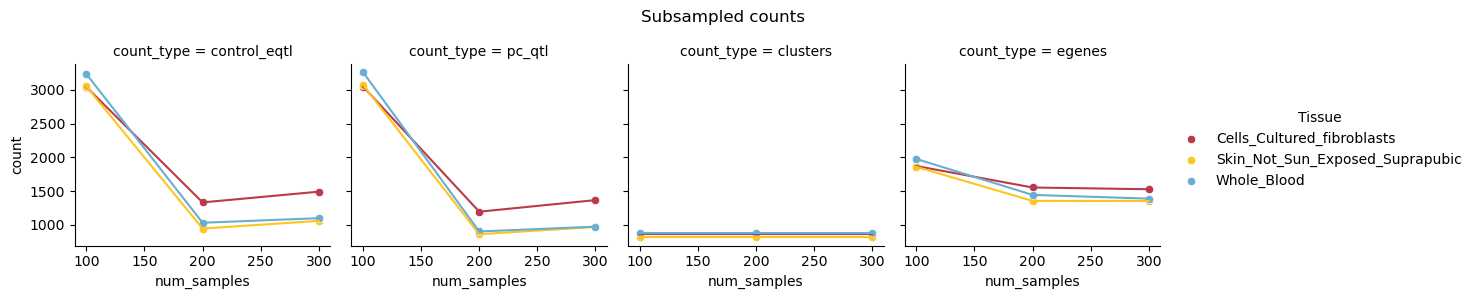

In [9]:
g = sns.FacetGrid(joined_counts, col="count_type", hue='Tissue', palette = tissue_pal)
g.map(sns.lineplot, "num_samples", "count")
g.map(sns.scatterplot, "num_samples", "count")
g.add_legend()
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Subsampled counts')

look at p values for each snp

In [12]:
sub_overlaps = {}
pc_nominals = {}
e_nominals = {}
for num_samples in subsample_nums:
    sub_overlaps[num_samples] = load_overlap(sub_config[num_samples], prefix)
    pc_nominals[num_samples] = load_pc_nominal(sub_config[num_samples], prefix)
    e_nominals[num_samples] = load_e_nominal(sub_config[num_samples], prefix)

In [13]:
e_nominals[100]['is_lead'] = e_nominals[100]['variant_id'].isin(sub_overlaps[100]['lead_variant_id'])
e_nominals[200]['is_lead'] = e_nominals[200]['variant_id'].isin(sub_overlaps[200]['lead_variant_id'])
e_nominal_merged = pd.merge(left=e_nominals[100], right=e_nominals[200],left_on=['phenotype_id', 'variant_id'], right_on=['phenotype_id', 'variant_id'], suffixes=['_100', '_200'])

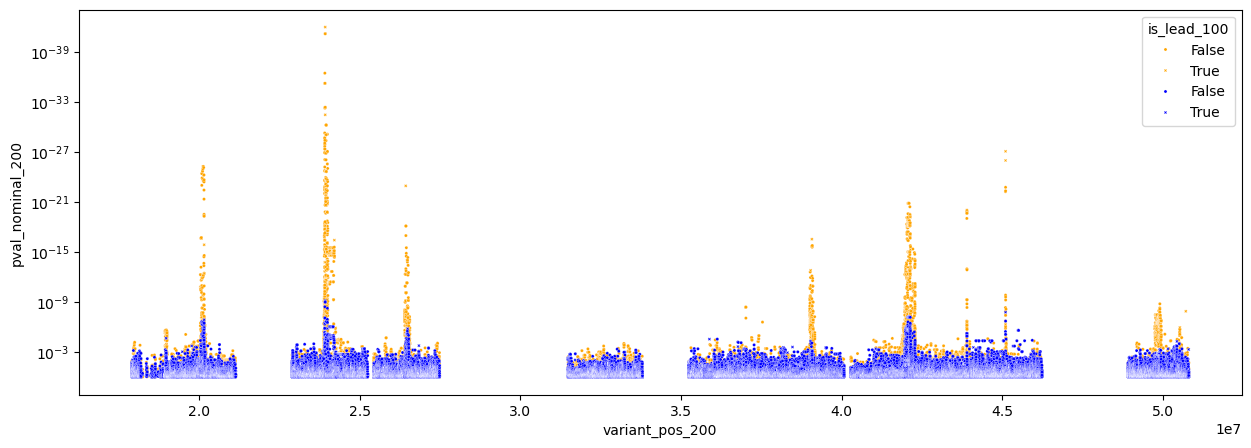

In [14]:
fig, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(e_nominal_merged, y='pval_nominal_200', x='variant_pos_200', ax=ax, color='orange', style='is_lead_200', s=5)
sns.scatterplot(e_nominal_merged, y='pval_nominal_100', x='variant_pos_100', ax=ax, color='blue', style='is_lead_100', s=5)

ax.set_yscale('log')
ax.invert_yaxis()


/local/scratch/klawren/slrmtmp.43875707/ipykernel_60405/2531595153.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(sub_overlaps[200][(sub_overlaps[200]['lead_variant_id'].str.contains('chr22'))&(sub_overlaps[100]['orig_cs_dataset']=='control_eqtl')]['variant_list'].str.split(',').apply(len), bins=range(0, 100), ax=ax, label='200')


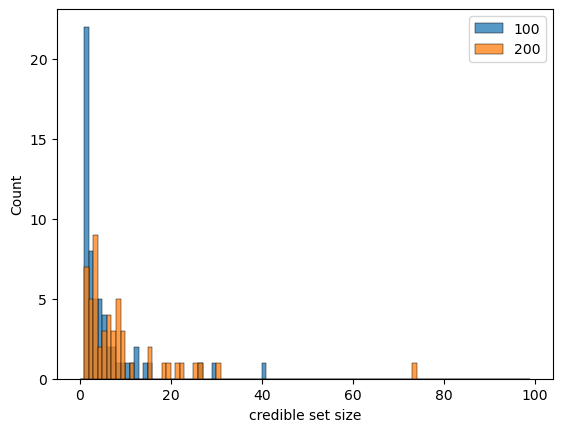

In [139]:
fig, ax = plt.subplots()
sns.histplot(sub_overlaps[100][(sub_overlaps[100]['lead_variant_id'].str.contains('chr22'))&(sub_overlaps[100]['orig_cs_dataset']=='control_eqtl')]['variant_list'].str.split(',').apply(len), bins=range(0, 100), ax=ax, label='100')
sns.histplot(sub_overlaps[200][(sub_overlaps[200]['lead_variant_id'].str.contains('chr22'))&(sub_overlaps[100]['orig_cs_dataset']=='control_eqtl')]['variant_list'].str.split(',').apply(len), bins=range(0, 100), ax=ax, label='200')
ax.set_ylabel('Count')
ax.set_xlabel('credible set size')

plt.legend()
